In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

In [2]:
# forest loss data
df_forest = pd.read_csv('Data/district_forest_cover.csv')

# SPEI growing period data
df_spei = pd.read_csv('Data/district_province_spei_growingperiod.csv')

# rename season_year column in SPEI df
df_spei = df_spei.rename(columns={'season_year': 'year'})

# population data
df_pop = pd.read_csv('Data/district_pop_growth.csv')

# clean columns
df_pop = df_pop.drop(columns=['Unnamed: 0'])

for df in [df_forest, df_pop, df_spei]:
    df['district'] = df['district'].str.strip().str.title()

# calculate population density
# load district shapefile
districts_gdf = gpd.read_file('Data/district.shp')

# set CRS
districts_gdf = districts_gdf.set_crs(epsg=4326)

# reproject to a metric CRS
districts_gdf = districts_gdf.to_crs(epsg=32735)

# compute area (square kilometers)
districts_gdf['district_area_km2'] = districts_gdf['geometry'].area / 1e6

# standardize district names
districts_gdf['district'] = districts_gdf['NAME_2'].str.strip().str.title()
df_pop['district'] = df_pop['district'].str.strip().str.title()

# drop geometry
area_df = districts_gdf[['district', 'district_area_km2']]

# merge with population
df_pop = df_pop.merge(area_df, on='district', how='left')

# calculate population density
df_pop['pop_density'] = df_pop['population'] / df_pop['district_area_km2']

merged = (df_forest
          .merge(df_pop,  on=['district', 'year'], how='outer')
          .merge(df_spei, on=['district', 'year'], how='outer'))

# calculate percent forest cover in 2000
merged['percent_forest_2000'] = (merged['forest_2000_m2'] / merged['district_area_km2']) * 100

# compute SPEI lags
merged = merged.sort_values(['district', 'year'])
for lag in range(0, 6):
    merged[f'mean_spei_lag{lag}'] = (
        merged.groupby('district')['mean_growing_spei'].shift(lag)
    )

model_vars = ['percent_loss_annual', 'mean_spei_lag5',
              'pop_density', 'percent_forest_2000']

cleaned = merged[
    (merged['year'].between(2001, 2020)) & 
    merged[model_vars].notna().all(axis=1)
].copy()

# center population density
cleaned['pop_density_c'] = cleaned['pop_density'] - cleaned['pop_density'].mean()

# center population growth
cleaned['pop_growth_c'] = cleaned['pop_growth'] - cleaned['pop_growth'].mean()
    
cleaned.head()

ERROR 1: PROJ: proj_create_from_database: Open of /mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/share/proj failed


,district,year,forest_cover_ha,loss_m2,percent_loss_annual,forest_2000_m2,population,pop_growth,district_area_km2,pop_density,...,province_avg_end_date,percent_forest_2000,mean_spei_lag0,mean_spei_lag1,mean_spei_lag2,mean_spei_lag3,mean_spei_lag4,mean_spei_lag5,pop_density_c,pop_growth_c
5,Chadiza,2005,23139.899515,3.930932e+05,0.169589,2.347779e+08,67476.906250,0.020426,1518.283564,44.442888,...,May 04,1.546337e+07,-0.699067,-0.079997,0.227219,0.281255,0.364988,0.841021,-36.166655,-0.005534
6,Chadiza,2006,22994.203303,1.456962e+06,0.629632,2.347779e+08,68212.812500,0.010906,1518.283564,44.927584,...,May 04,1.546337e+07,0.170735,-0.699067,-0.079997,0.227219,0.281255,0.364988,-35.681959,-0.015054
7,Chadiza,2007,22914.760500,7.944280e+05,0.345491,2.347779e+08,68965.882812,0.011040,1518.283564,45.423585,...,May 04,1.546337e+07,0.760298,0.170735,-0.699067,-0.079997,0.227219,0.281255,-35.185958,-0.014920
8,Chadiza,2008,22654.299450,2.604611e+06,1.136652,2.347779e+08,71330.296875,0.034284,1518.283564,46.980879,...,May 04,1.546337e+07,0.189313,0.760298,0.170735,-0.699067,-0.079997,0.227219,-33.628663,0.008324
9,Chadiza,2009,22560.725768,9.357368e+05,0.413050,2.347779e+08,71971.171875,0.008985,1518.283564,47.402984,...,May 04,1.546337e+07,1.762190,0.189313,0.760298,0.170735,-0.699067,-0.079997,-33.206559,-0.016975


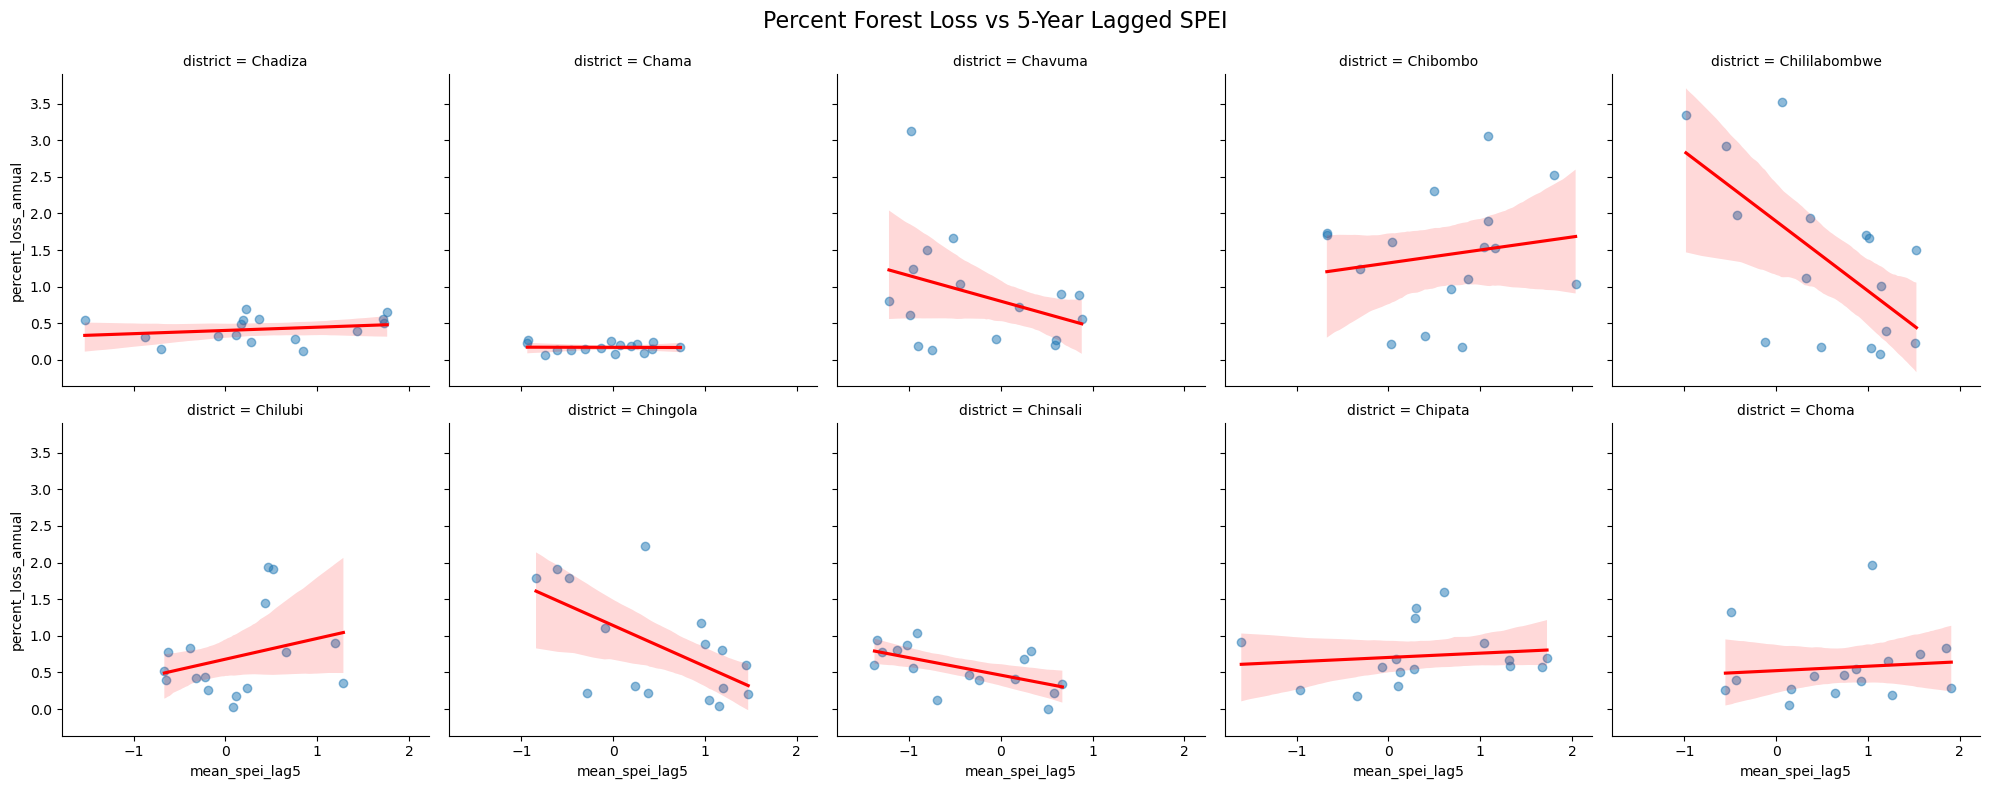

In [19]:
g = sns.lmplot(
    data=subset,
    x='mean_spei_lag5',
    y='percent_loss_annual',
    col='district',
    col_wrap=5, 
    height=4,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percent Forest Loss vs 5-Year Lagged SPEI', fontsize=16)
plt.show()

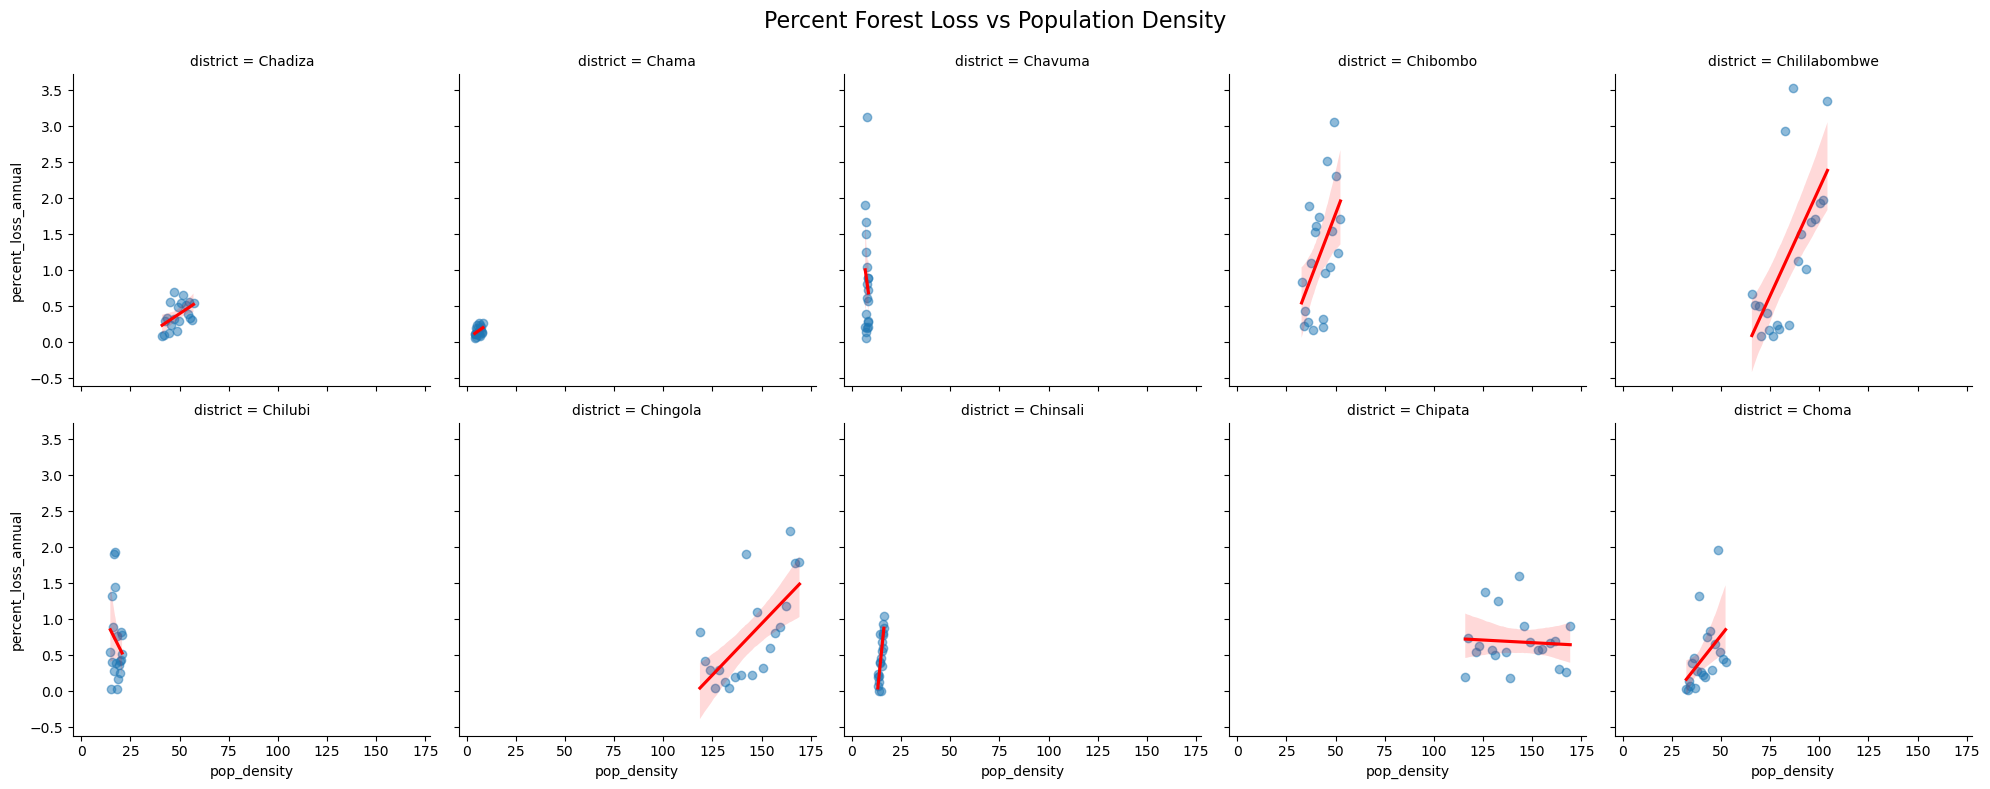

In [25]:
top10_districts = cleaned['district'].dropna().sort_values().unique()[:10]

subset = cleaned[cleaned['district'].isin(top10_districts)].copy()

g = sns.lmplot(
    data=subset,
    x='pop_density',
    y='percent_loss_annual',
    col='district',
    col_wrap=5, 
    height=4,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percent Forest Loss vs Population Density', fontsize=16)
plt.show()

In [3]:
# test which lag is best predictor
results = {}

for lag in range(0, 6):
    spei_col = f'mean_spei_lag{lag}'
    formula = (
        f'percent_loss_annual ~ pop_growth + pop_density + mean_spei_lag{lag} + C(district)'
    )
    
    model = smf.ols(formula, data=cleaned).fit()
    
    results[f'Lag {lag}'] = {
        'Intercept': model.params.get('Intercept', float('nan')),
        'SPEI coef': model.params.get(spei_col, float('nan')),
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic,
        'pval_spei': model.pvalues.get(f'mean_spei_lag{lag}', None)
    }

# Convert results to DataFrame
import pandas as pd
lag_comparison = pd.DataFrame(results).T
lag_comparison = lag_comparison.sort_values(by='Adj. R-squared', ascending=False)

lag_comparison

,Intercept,SPEI coef,R-squared,Adj. R-squared,AIC,BIC,pval_spei
Lag 5,0.500545,-0.171570,0.370448,0.327652,5292.822398,5924.297471,5.422185e-08
Lag 4,0.465133,-0.161638,0.370075,0.327253,5293.883565,5925.358638,9.051707e-08
Lag 3,0.445920,-0.091826,0.362855,0.319543,5314.305979,5945.781052,2.099156e-03
Lag 2,0.441199,-0.076938,0.361756,0.318369,5317.394053,5948.869127,1.036125e-02
Lag 0,0.428723,0.049097,0.360323,0.316839,5321.412555,5952.887629,9.354942e-02
Lag 1,0.432014,0.047804,0.360217,0.316725,5321.710604,5953.185678,1.114618e-01


In [5]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

# Lags to compare
lags = [0, 1, 2, 3, 4, 5]

# Build results table by refitting once per lag
rows = []
for L in lags:
    spei_name = f"mean_spei_lag{L}"
    # Use a consistent spec across lags (match your main model controls as needed)
    # Example spec:
    formula = (
        f'log_loss_m2 ~ {spei_name} + pop_density_wi + percent_forest_2000 + C(district)'
    )
    m = smf.ols(formula, data=cleaned).fit()

    rows.append({
        "lag": L,
        "coef": m.params.get(spei_name, np.nan),
        "se": m.bse.get(spei_name, np.nan),
        "pval": m.pvalues.get(spei_name, np.nan),
        "r2": m.rsquared,
        "adj_r2": m.rsquared_adj,
        "AIC": m.aic,
        "BIC": m.bic,
    })

lag_comparison = pd.DataFrame(rows).sort_values("lag").reset_index(drop=True)

# CIs
lag_comparison["ci_lower"] = lag_comparison["coef"] - 1.96 * lag_comparison["se"]
lag_comparison["ci_upper"] = lag_comparison["coef"] + 1.96 * lag_comparison["se"]

# Plot
plt.figure(figsize=(7.5,5))
plt.errorbar(
    lag_comparison["lag"],
    lag_comparison["coef"],
    yerr=1.96*lag_comparison["se"],
    fmt='o',
    color="navy",
    ecolor="skyblue",
    elinewidth=2,
    capsize=4,
    markersize=6,
    label="SPEI coefficient"
)
plt.axhline(0, color="gray", ls="--", lw=1)
plt.xlabel("Lag (years)")
plt.ylabel("Effect of drought (SPEI) on log forest loss")
plt.title("Drought Effects on Forest Loss at Different Lags")
plt.legend(frameon=True, facecolor="white", edgecolor="gray")
plt.tight_layout()
plt.show()

PatsyError: Error evaluating factor: NameError: name 'pop_density_wi' is not defined
    log_loss_m2 ~ mean_spei_lag0 + pop_density_wi + percent_forest_2000 + C(district)
                                   ^^^^^^^^^^^^^^

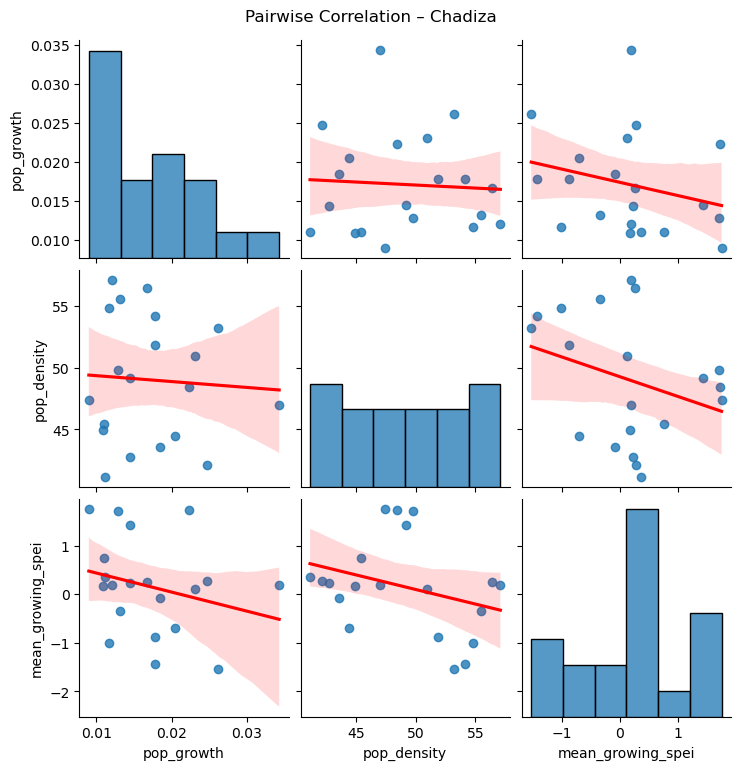

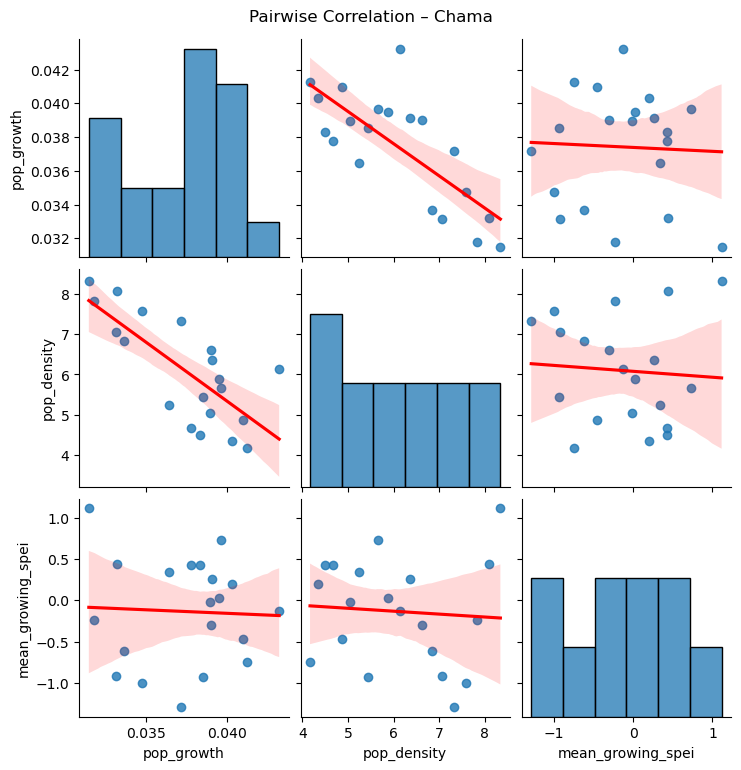

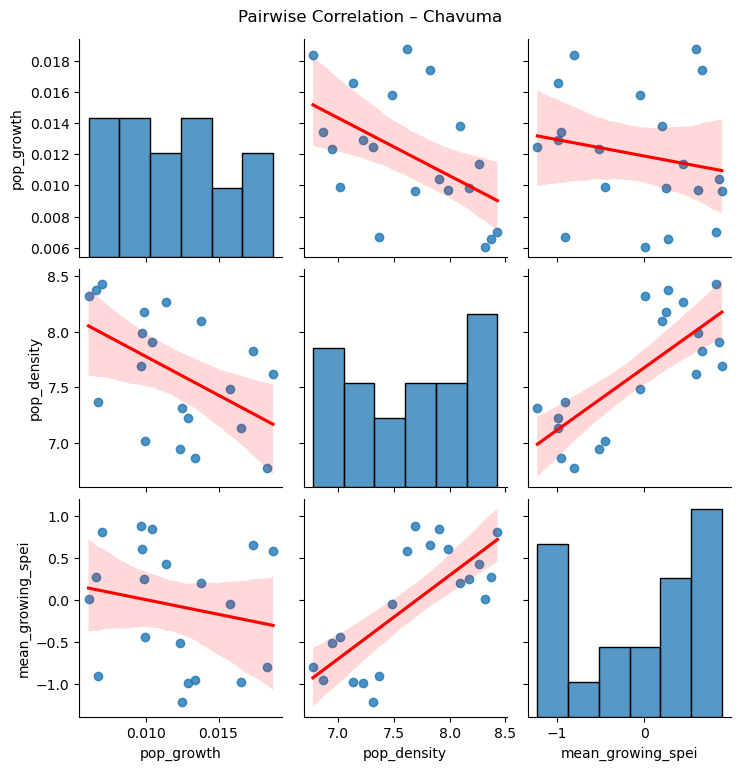

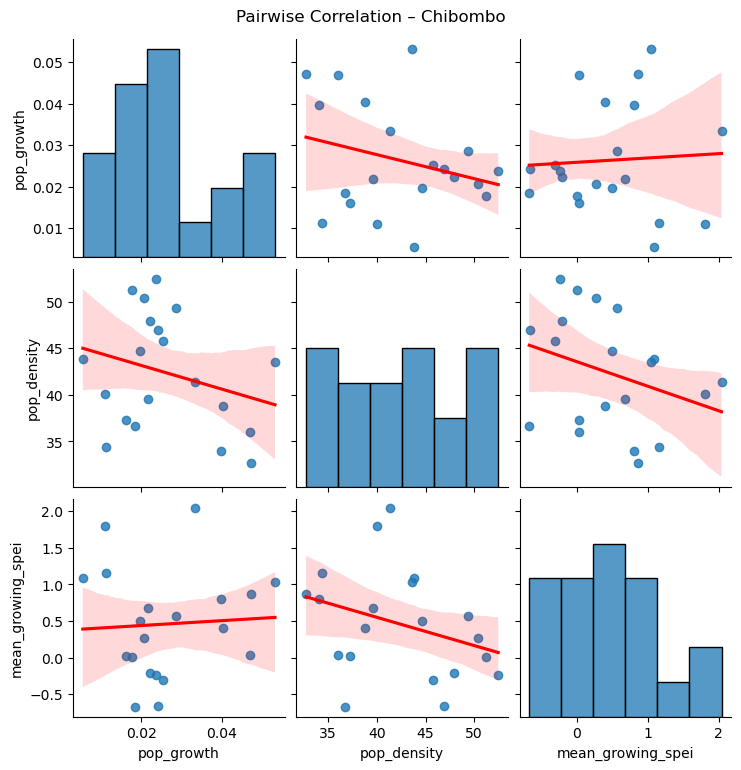

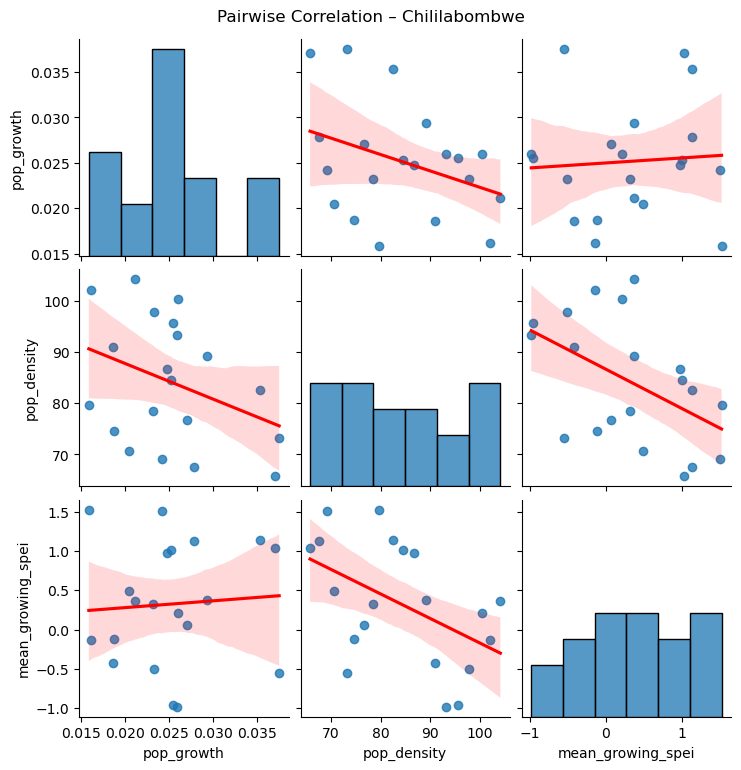

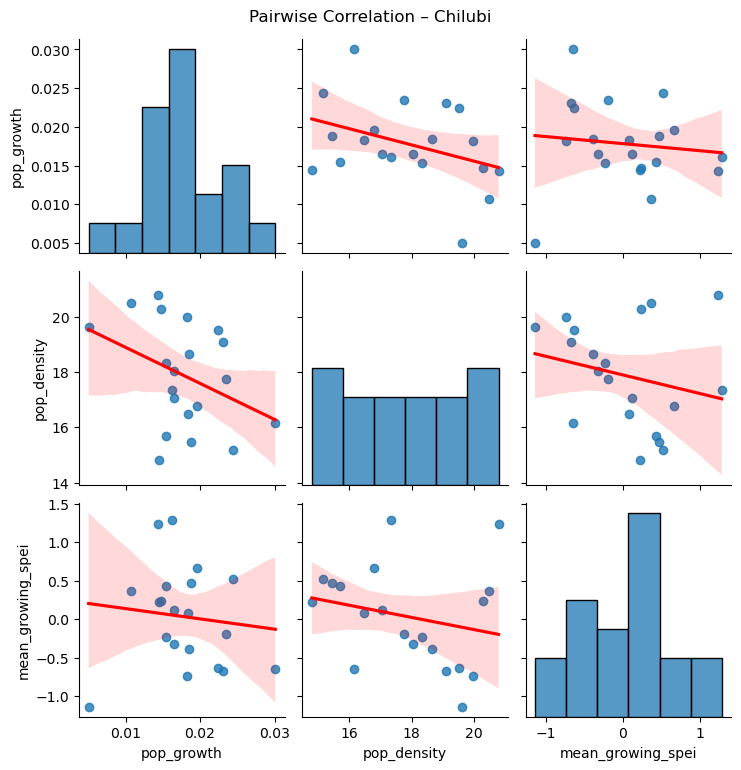

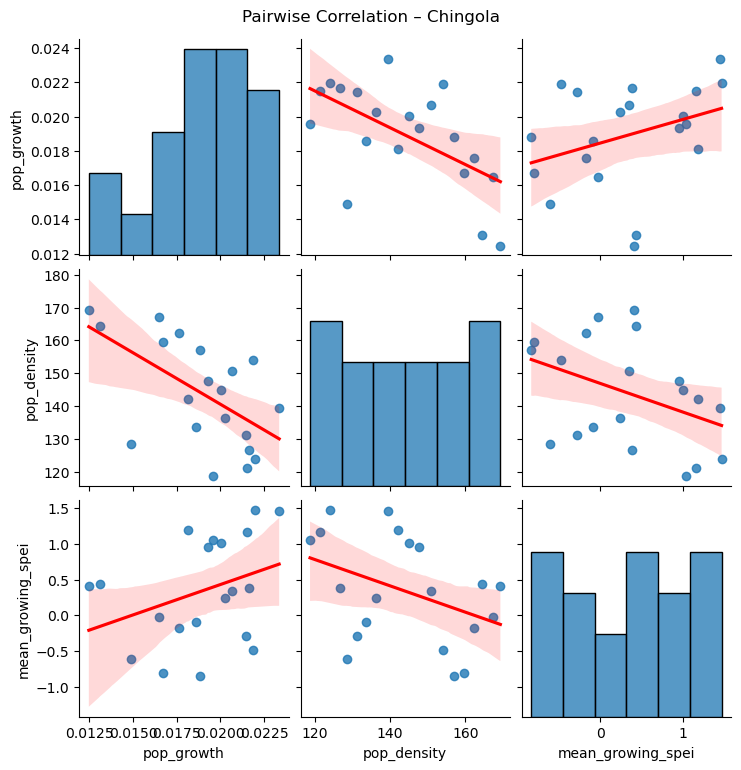

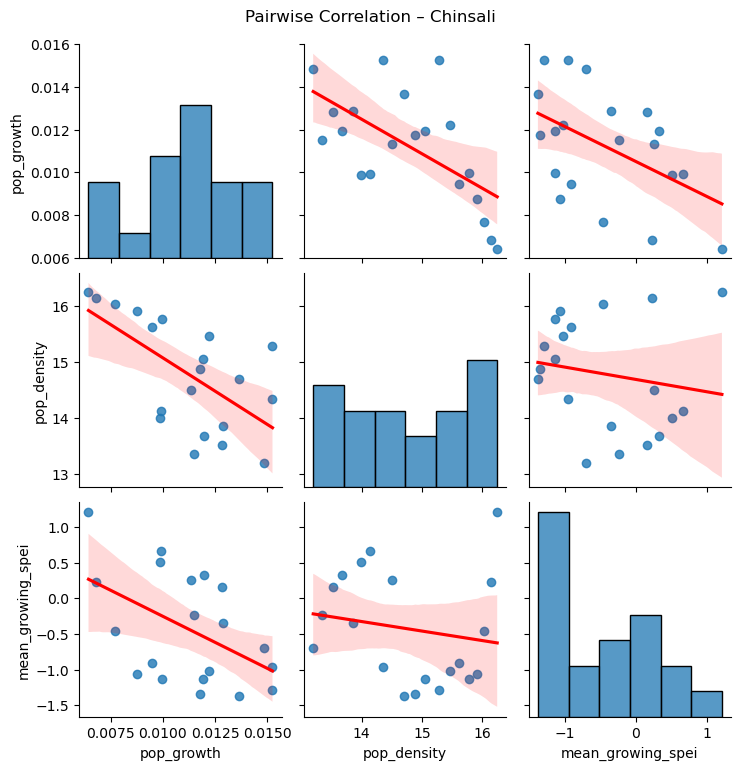

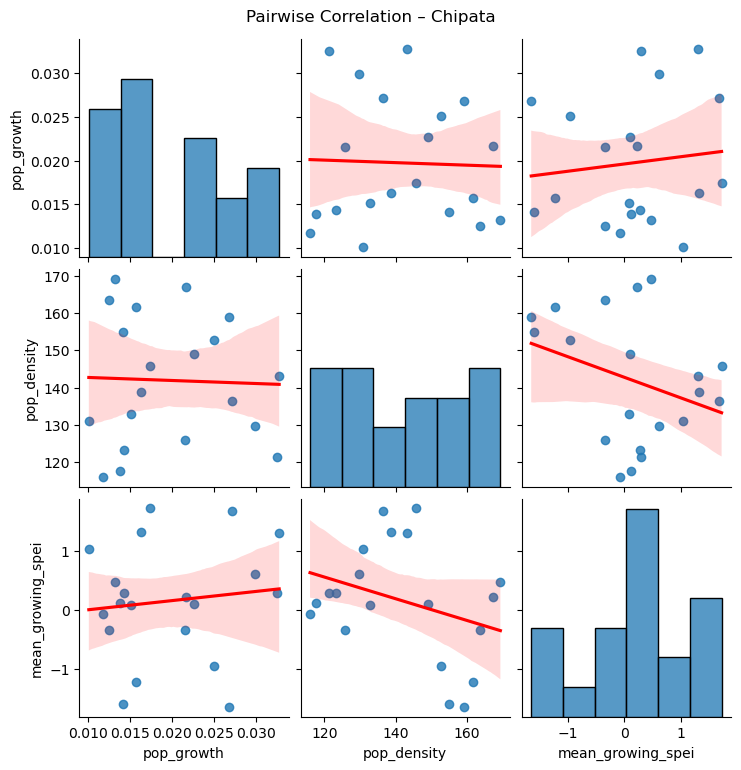

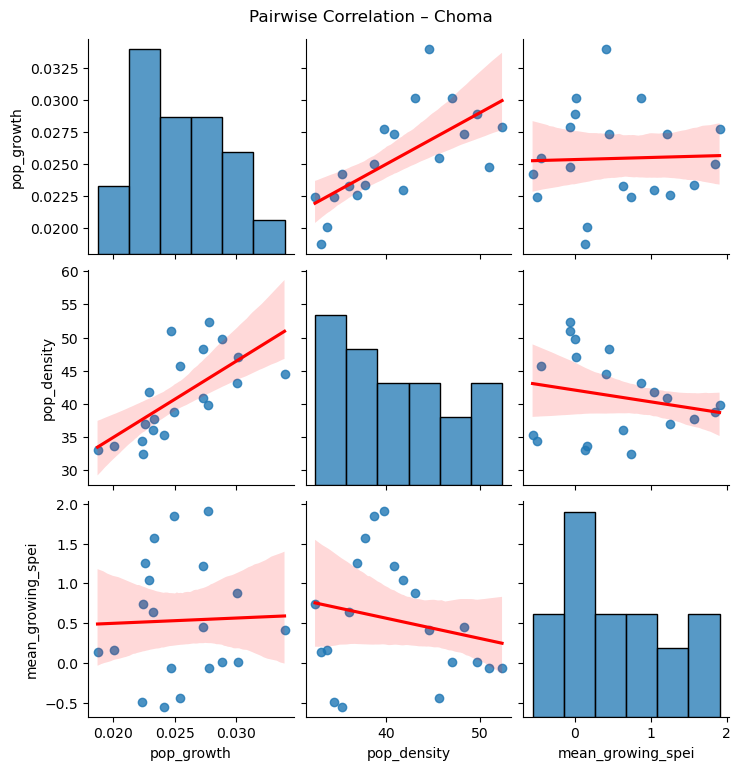

In [27]:
predictors = ['pop_growth', 'pop_density', 'mean_growing_spei']

for district in top10_districts:
    district_df = cleaned[cleaned['district'] == district]
    
    sns.pairplot(district_df[predictors], kind='reg', 
                 plot_kws={'line_kws': {'color': 'red'}})
    plt.suptitle(f'Pairwise Correlation – {district}', y=1.02)
    plt.show()

In [21]:
# scale population density
# for every 100 person per km^2 increase in pop density, annual forest loss increases by 0.062%
cleaned['pop_density_c_scaled'] = cleaned['pop_density_c'] / 100

In [20]:
# within-district centering to isolate changes over time
cleaned['pop_density_wi'] = (
    cleaned['pop_density_c_scaled'] -
    cleaned.groupby('district')['pop_density_c_scaled'].transform('mean')
)

In [26]:
# create interaction term
cleaned['spei5_x_popdens'] = cleaned['mean_spei_lag5'] * cleaned['pop_density_wi']

In [27]:
model = smf.ols(
    formula='percent_loss_annual ~ C(district) + mean_spei_lag5 + pop_density_wi + spei5_x_popdens',
    data=cleaned
).fit()

# view summary
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_loss_annual   R-squared:                       0.405
Model:                             OLS   Adj. R-squared:                  0.364
Method:                  Least Squares   F-statistic:                     9.887
Date:                 Tue, 17 Jun 2025   Prob (F-statistic):           1.14e-75
Time:                         11:08:20   Log-Likelihood:                -1588.4
No. Observations:                 1104   AIC:                             3321.
Df Residuals:                     1032   BIC:                             3681.
Df Model:                           71                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Interc

In [24]:
# check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np

# Choose the variables used in the model (excluding district dummies)
X = cleaned[['mean_spei_lag5', 'pop_density_wi', 'spei5_x_popdens', 'percent_forest_2000']]
X = add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# log-transformed outcome
cleaned['log_loss'] = np.log1p(cleaned['percent_loss_annual'])

model_log = smf.ols(
    'log_loss ~ mean_spei_lag5 + pop_density_wi + spei5_x_popdens + percent_forest_2000 + C(district)',
    data=cleaned
).fit()

print(model_log.summary())

              variable       VIF
0                const  2.242208
1       mean_spei_lag5  1.031116
2       pop_density_wi  1.376252
3      spei5_x_popdens  1.378567
4  percent_forest_2000  1.027776
                            OLS Regression Results                            
Dep. Variable:               log_loss   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     11.40
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           6.79e-88
Time:                        11:06:50   Log-Likelihood:                -264.95
No. Observations:                1104   AIC:                             673.9
Df Residuals:                    1032   BIC:                             1034.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
            

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

y, X = dmatrices('percent_loss_annual ~ mean_spei_lag5 + pop_density_wi + spei5_x_popdens + C(district)', data=cleaned, return_type='dataframe')
vif_df = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_df)

                         feature        VIF
0                      Intercept  69.266887
1           C(district)[T.Chama]   1.977029
2         C(district)[T.Chavuma]   1.980714
3        C(district)[T.Chibombo]   1.972141
4   C(district)[T.Chililabombwe]   1.971535
..                           ...        ...
67        C(district)[T.Solwezi]   1.971037
68        C(district)[T.Zambezi]   1.972843
69                mean_spei_lag5   1.282536
70                pop_density_wi   1.378651
71               spei5_x_popdens   1.386428

[72 rows x 2 columns]


## ANOVA for pop_density

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fit an anova model to confirm that population density is explained by district
anova_model = smf.ols('pop_density_c_scaled ~ C(district)', data=cleaned).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                   sum_sq      df           F  PR(>F)
C(district)  33693.471842    68.0  283.684179     0.0
Residual      1807.765461  1035.0         NaN     NaN


Text(0.5, 0.98, 'Predicted vs Actual Forest Loss by District')

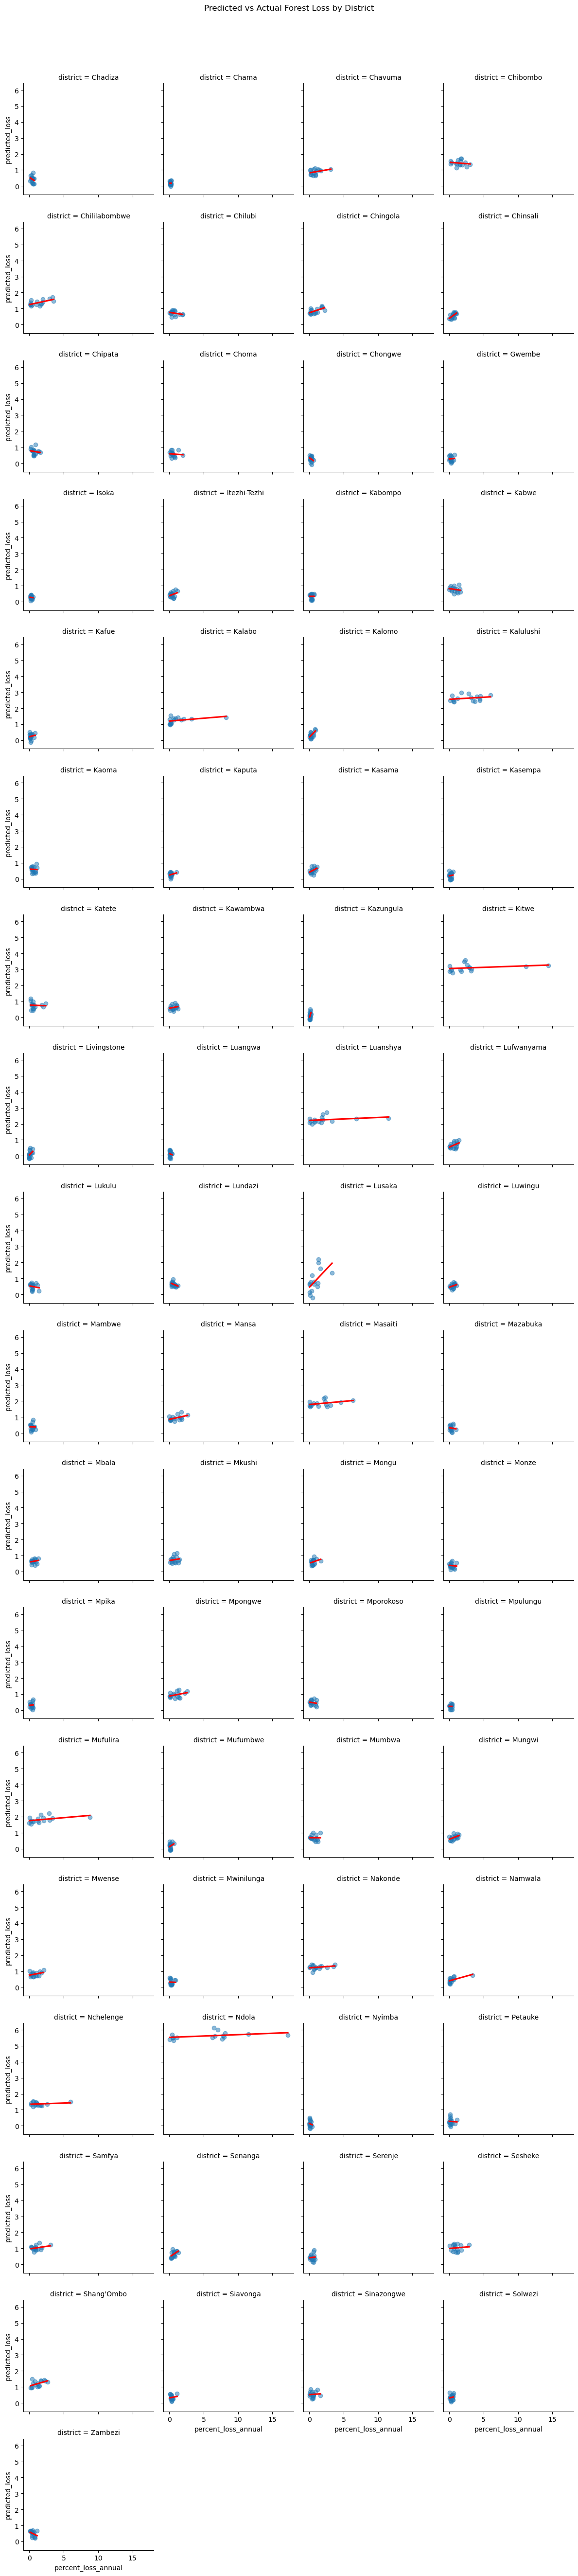

In [36]:
g = sns.lmplot(
    data=cleaned,
    x='percent_loss_annual',
    y='predicted_loss',
    col='district',
    col_wrap=4,
    height=3,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ci=None
)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Predicted vs Actual Forest Loss by District')

In [37]:
# Get model summary as a DataFrame
summary_df = model.summary2().tables[1].copy()

# Filter only district fixed effects
district_effects = summary_df.filter(like='C(district)', axis=0)

# Sort by p-value
most_significant_districts = district_effects.sort_values(by='P>|t|')

# View top 10 most significant (lowest p-values)
print(most_significant_districts.head(10))

AttributeError: 'MixedLM' object has no attribute 'summary2'

In [38]:
# Ensure predictions exist
cleaned['predicted_loss'] = model.predict(cleaned)

# Top 10 significant districts
top_districts = [
    'Ndola', 'Kitwe', 'Kalulushi', 'Luanshya', 'Masaiti',
    'Mufulira', 'Chibombo', 'Chililabombwe', 'Kalabo', 'Nchelenge'
]

# Filter to just those districts
subset = cleaned[cleaned['district'].isin(top_districts)].copy()

# Plot
g = sns.FacetGrid(
    subset,
    col='district',
    col_wrap=5,
    height=4,
    aspect=1.2,
    sharey=False
)

g.map_dataframe(sns.lineplot, x='year', y='percent_loss_annual', label='Actual', marker='o')
g.map_dataframe(sns.lineplot, x='year', y='predicted_loss', label='Predicted', marker='o', linestyle='--')

# Add legends manually to each subplot
for ax in g.axes.flatten():
    ax.legend(loc='best')

g.set_titles('{col_name}')
g.set_axis_labels('Year', 'Forest Loss (%)')
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Actual vs. Predicted Forest Loss in Top 10 Districts', fontsize=16)
plt.tight_layout()
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

## Fixed effects model

In [8]:
cleaned.head()

,district,year,forest_cover_ha,loss_m2,percent_loss_annual,forest_2000_m2,population,pop_growth,district_area_km2,pop_density,...,province_avg_start_date,province_avg_end_date,percent_forest_2000,pop_density_c,pop_growth_c,mean_spei_lag1,mean_spei_lag2,mean_spei_lag3,mean_spei_lag4,mean_spei_lag5
0,Chadiza,2001,57181.013721,5.136993e+05,0.089757,5.723238e+08,62463.820312,0.011073,1518.283564,41.141077,...,November 26,May 04,3.769545e+07,-68.329621,-0.015144,NaN,NaN,NaN,NaN,NaN
1,Chadiza,2002,57127.207503,5.380622e+05,0.094098,5.723238e+08,64005.617188,0.024683,1518.283564,42.156563,...,November 26,May 04,3.769545e+07,-67.314134,-0.001534,0.364988,NaN,NaN,NaN,NaN
2,Chadiza,2003,56960.977318,1.662302e+06,0.290983,5.723238e+08,64927.222656,0.014399,1518.283564,42.763568,...,November 26,May 04,3.769545e+07,-66.707129,-0.011818,0.281255,0.364988,NaN,NaN,NaN
3,Chadiza,2004,56773.795452,1.871819e+06,0.328614,5.723238e+08,66126.242188,0.018467,1518.283564,43.553289,...,November 26,May 04,3.769545e+07,-65.917409,-0.007750,0.227219,0.281255,0.364988,NaN,NaN
4,Chadiza,2005,56703.324923,7.047053e+05,0.124125,5.723238e+08,67476.906250,0.020426,1518.283564,44.442888,...,November 26,May 04,3.769545e+07,-65.027809,-0.005792,-0.079997,0.227219,0.281255,0.364988,NaN


In [28]:
model_vars = [
    'percent_loss_annual', 'mean_spei_lag5',
    'pop_density_c', 'percent_forest_2000', 'district'
]

cleaned_model = cleaned.dropna(subset=model_vars).reset_index(drop=True)

model = smf.mixedlm(
    'percent_loss_annual ~ mean_spei_lag5 + pop_density_c + percent_forest_2000',
    data=cleaned_model,
    groups=cleaned_model['district']
)

result = model.fit()
print(result.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: percent_loss_annual
No. Observations: 1104    Method:             REML               
No. Groups:       69      Scale:              1.1160             
Min. group size:  16      Log-Likelihood:     -1735.3731         
Max. group size:  16      Converged:          Yes                
Mean group size:  16.0                                           
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.934    0.143  6.556 0.000  0.655  1.214
mean_spei_lag5         -0.204    0.040 -5.052 0.000 -0.284 -0.125
pop_density_c           0.000    0.000  2.284 0.022  0.000  0.001
percent_forest_2000    -0.000    0.000 -0.897 0.370 -0.000  0.000
Group Var               0.633    0.120                           



In [13]:
print("All districts:", cleaned['district'].nunique())
print("Used in model:", cleaned_model['district'].nunique())

All districts: 69
Used in model: 69
